# Intelligent Multimedia Analysis - Deep Learning Vision Code
Christian Willig 

# Load packages

In [1]:
import os
import pathlib
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gdown

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List
from torch.utils.data import Dataset
from torchvision.io import read_image
from tqdm.auto import tqdm
from zipfile import ZipFile

# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

c:\Users\WIL106452\Documents\Learning\Python\pytorch\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mlxtend version: 0.23.1


# Setting device

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Variables

In [3]:
train_images_path = ".//dataset//seg_train"
test_images_path = ".//dataset//seg_test"

BATCH_SIZE = 32
# Set number of epochs
NUM_EPOCHS = 20

LEARNING_RATE = 0.005

# Loading and pre-processing dataset

### Dataset download

In [45]:
# Intel images: https://drive.google.com/file/d/1UC4yMPJAB1XCcpiApJ44_KLIqLoGk5m1/view?usp=sharing

!gdown "1UC4yMPJAB1XCcpiApJ44_KLIqLoGk5m1&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1UC4yMPJAB1XCcpiApJ44_KLIqLoGk5m1&confirm=t
To: c:\Users\WIL106452\Documents\Learning\Python\pytorch\Intel Image dataset.zip

  0%|          | 0.00/362M [00:00<?, ?B/s]
  0%|          | 524k/362M [00:00<04:49, 1.25MB/s]
  0%|          | 1.57M/362M [00:00<01:48, 3.33MB/s]
  1%|          | 3.15M/362M [00:00<01:02, 5.74MB/s]
  1%|▏         | 4.72M/362M [00:00<00:49, 7.27MB/s]
  2%|▏         | 6.29M/362M [00:00<00:41, 8.60MB/s]
  2%|▏         | 7.34M/362M [00:01<00:39, 9.01MB/s]
  2%|▏         | 8.91M/362M [00:01<00:36, 9.81MB/s]
  3%|▎         | 10.5M/362M [00:01<00:34, 10.1MB/s]
  3%|▎         | 12.1M/362M [00:01<00:32, 10.6MB/s]
  4%|▍         | 13.6M/362M [00:01<00:32, 10.6MB/s]
  4%|▍         | 15.2M/362M [00:01<00:31, 10.9MB/s]
  5%|▍         | 16.8M/362M [00:01<00:31, 11.1MB/s]
  5%|▌         | 18.4M/362M [00:02<00:31, 11.0MB/s]
  5%|▌         | 19.9M/362M [00:02<00:30, 11.2MB/s]
  6%|▌         | 21.5M/362M [00:02<00:31, 11.0MB/s]


In [4]:
# !unzip -o ./Intel_Image_dataset.zip

# zip file name 
file_name = "Intel_Image_dataset.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zipf: 
    # printing all the contents of the zip file 
    zipf.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zipf.extractall() 
    print('Done!')

File Name                                             Modified             Size
seg_pred/                                      2024-07-15 21:56:02            0
seg_pred/10004.jpg                             2019-10-18 05:19:14        22337
seg_pred/10005.jpg                             2019-10-18 05:19:14        10295
seg_pred/10012.jpg                             2019-10-18 05:19:16        18143
seg_pred/10013.jpg                             2019-10-18 05:19:18        12449
seg_pred/10017.jpg                             2019-10-18 05:19:22        16377
seg_pred/10021.jpg                             2019-10-18 05:19:22        24750
seg_pred/1003.jpg                              2019-10-18 05:19:26        10860
seg_pred/10034.jpg                             2019-10-18 05:19:28        10908
seg_pred/10038.jpg                             2019-10-18 05:19:32        11534
seg_pred/10040.jpg                             2019-10-18 05:19:34        15915
seg_pred/10043.jpg                      

### Dataset exploration

In [5]:
train_df = pd.DataFrame()
classes = []
counts = []

for dirpath, dirnames, filenames in os.walk(train_images_path):
    classes.append(os.path.basename(dirpath))
    counts.append(len(filenames))
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 6 directories and 0 images in './/dataset//seg_train'.
There are 0 directories and 2191 images in './/dataset//seg_train\buildings'.
There are 0 directories and 2271 images in './/dataset//seg_train\forest'.
There are 0 directories and 2404 images in './/dataset//seg_train\glacier'.
There are 0 directories and 2512 images in './/dataset//seg_train\mountain'.
There are 0 directories and 2274 images in './/dataset//seg_train\sea'.
There are 0 directories and 2382 images in './/dataset//seg_train\street'.


As we can see in the chart below, the distribution of classes is pretty even among the classes. This is a good thing for training as we won't have to worry about unbalanced dataset.

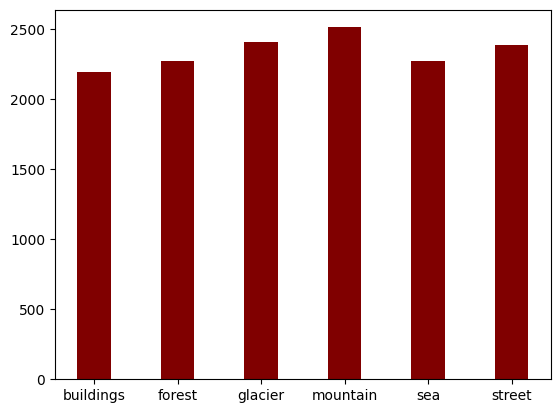

In [6]:
train_df['Class'] = classes
train_df['Counts'] = counts
train_df.drop(index=0, inplace=True)
plt.bar(train_df['Class'], train_df['Counts'], color ='maroon',width = 0.4);

In [7]:
test_df = pd.DataFrame()
classes = []
counts = []

for dirpath, dirnames, filenames in os.walk(test_images_path):
    classes.append(os.path.basename(dirpath))
    counts.append(len(filenames))
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 6 directories and 0 images in './/dataset//seg_test'.
There are 0 directories and 437 images in './/dataset//seg_test\buildings'.
There are 0 directories and 474 images in './/dataset//seg_test\forest'.
There are 0 directories and 553 images in './/dataset//seg_test\glacier'.
There are 0 directories and 525 images in './/dataset//seg_test\mountain'.
There are 0 directories and 510 images in './/dataset//seg_test\sea'.
There are 0 directories and 501 images in './/dataset//seg_test\street'.


And now we plot the distribution of the classes in the test dataset.

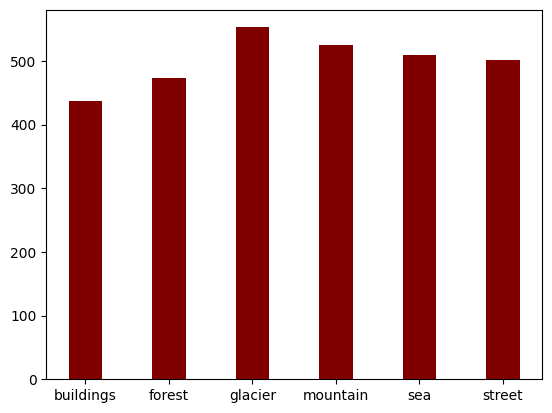

In [8]:
test_df['Class'] = classes
test_df['Counts'] = counts
test_df.drop(index=0, inplace=True)
plt.bar(test_df['Class'], test_df['Counts'], color ='maroon',width = 0.4);

How big are the images?
We can see that images are 150x150 pixels.

Random image path: dataset\seg_train\sea\19122.jpg
Image class: sea
Image height: 150
Image width: 150


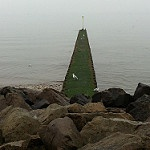

In [9]:
import random
from PIL import Image
from pathlib import Path

# Setup path to data folder
data_path = Path("./dataset/")
image_path = data_path / "seg_train"

# Set seed
random.seed(42)

image_path_list = list(image_path.glob("*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

### Dataset loading into pytorch

Pytorch uses two ways of loading data:

1. By using class ImageFolder.
2. By creating custom dataset class.

Given the structure of the dataset, one folder per class and images inside each class folder, we'll use option 1. When working with product-10k dataset, the structure of the folders and images was different and option 2 was a better approach for loading the data into pytorch.

In [10]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_images_path, # target folder of images
                                  transform=transforms.Compose([transforms.ToTensor()]), # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_images_path, 
                                 transform=transforms.Compose([transforms.ToTensor()]))

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 14034
    Root location: .//dataset//seg_train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 3000
    Root location: .//dataset//seg_test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


What are the classes contained in this dataset?

In [11]:
# Get class names as a list
class_names = train_data.classes
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

The train and test datasets are not big, 14k images for training and 3000 for testing.

In [12]:
# Check datasets lengths
len(train_data), len(test_data)

(14034, 3000)

Computing the mean and std over all the training dataset. For the standard deviation we will be aproaching it by adding the variances and then calculating the square root of the variance to get the standard deviation.

In [13]:
from torch.utils.data import DataLoader

train_data = datasets.ImageFolder(root=train_images_path, # target folder of images
                                  transform=transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()]), # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

data_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)

def calc_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

mean, std = calc_mean_std(data_loader)

print("mean: " + str(mean))
print("std: " + str(std))

100%|██████████| 220/220 [00:23<00:00,  9.31it/s]


mean: tensor([0.4300, 0.4573, 0.4537])
std: tensor([0.2693, 0.2679, 0.2983])


### Dataset transformations
The transformations to be perform over the images needs to be defined first before creating the dataloader. 

- We'll make sure that all images are sized based on the model architecture. LeNet5 (32x32), AlexNet (227x227) and VGGNet (224x224).
- we'll apply a random horizontal flip on the image with a 50% probability.
- We'll normalise the colours of the images.

These transformations will be applied randomly and dynamically while getting and loading the images, this way the model will see "different" images in each epoch of training, which will help the model generalise better.

In [14]:
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)), # This transforamtion will change based on the model
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor() ,
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

Now we create out pytorch dataset with the transformations we created above

In [15]:
train_data = datasets.ImageFolder(root=train_images_path, # target folder of images
                                  transform=train_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_images_path, 
                                 transform=test_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 14034
    Root location: .//dataset//seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=tensor([0.4300, 0.4573, 0.4537]), std=tensor([0.2693, 0.2679, 0.2983]))
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 3000
    Root location: .//dataset//seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=tensor([0.4300, 0.4573, 0.4537]), std=tensor([0.2693, 0.2679, 0.2983]))
           )


### Dataset splits

We'll take 20% of the training dataset for validation purposes. We'll use the test data for calculating the final performance of the models.

In [16]:
from torch.utils.data import random_split

torch.manual_seed(42)

validation_size = int(len(train_data) * 0.2)
train_size = len(train_data) - validation_size

train_ds, val_ds = random_split(train_data, [train_size, validation_size])
len(train_ds), len(val_ds)

(11228, 2806)

### Dataloaders
The dataloaders are special stuctures in pytorch that facilitates the training process by providing an iterable over the dataset. We will use a batch size of 32, as defined in the variable section. We tried with 128 and 64 but the model couldn't fit in out 8GB GPU memory, so we ended up with 32.

In [17]:
# Turn train and validation Datasets into DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_ds, 
                              batch_size=BATCH_SIZE, # specify many samples per batch
                              num_workers=2, # specify how many subprocesses to use for data loading
                              shuffle=True, # shuffle the data
                              pin_memory=True) 

val_dataloader = DataLoader(dataset=val_ds, 
                              batch_size=BATCH_SIZE, 
                              num_workers=2, 
                              shuffle=True,
                              pin_memory=True) 

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=2, 
                             shuffle=False) 

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1db2dfc5c90>,
 <torch.utils.data.dataloader.DataLoader at 0x1db2dfc4e50>)

With this dataloader we can now visualise some examples of images by class.

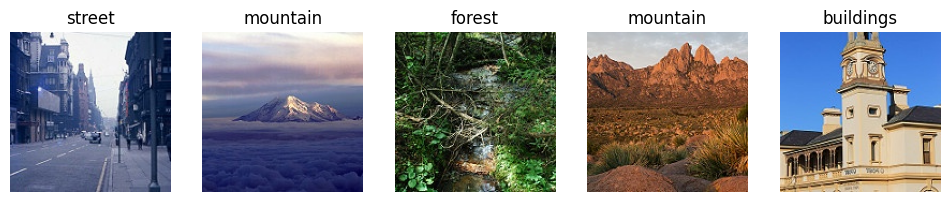

In [18]:
def undo_normalize(image: torch.Tensor, mean: List[float], std: List[float]) -> np.array:
    # Undo the normalization from single image
    # return numpy array with image order dim     
    
    for channel, (mean_val, std_val) in enumerate(zip(mean, std)):
        image[channel] = (image[channel] * std_val) + mean_val
    image = torch.clamp(image, 0, 1)
    return image.numpy().transpose((1, 2, 0))

def explore_images(batch: torch.Tensor, labels: List[int], class_names: Dict, num_images=5):
    # Show images from batch   
    
    indices = np.random.choice(len(batch), num_images, replace=False)

    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

    for i, ax in enumerate(axes):
        idx = indices[i]
        image = batch[idx].clone() 
        image = undo_normalize(image, mean, std)
        
        label = labels[idx].item()
        class_name = class_names[label]
        
        ax.imshow(image)
        ax.set_title(class_name)
        ax.axis('off')

    plt.show()

first_train_batch = next(iter(train_dataloader))
explore_images(first_train_batch[0], first_train_batch[1], ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

# Model design and implementation
Templates and inspiration: https://github.com/bentrevett/pytorch-image-classification/blob/master/README.md

### Lenet5
This model has been found to have good performance as a CNN architecture for image recognition. It was developed by Yann LeCunn in 1990.

In [19]:
class LeNet5(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Layer 1: Convolutional layer with 6 output channels, 5x5 kernel size, stride of 1, no padding
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),  # Batch normalization for 6 feature maps
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with a 2x2 window and stride of 2
        )
        # Layer 2: Convolutional layer with 16 output channels, 5x5 kernel size, stride of 1, no padding
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),  # Batch normalization for 16 feature maps
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with a 2x2 window and stride of 2
        )
        # Fully connected layer: Linear transformation from the 400-dimensional vector to a 120-dimensional vector
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()  # ReLU activation function
        # Fully connected layer: Linear transformation from the 120-dimensional vector to an 84-dimensional vector
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()  # ReLU activation function
        # Output layer: Linear transformation from the 84-dimensional vector to the number of classes
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        # Forward pass through Layer 1
        out = self.layer1(x)
        # Forward pass through Layer 2
        out = self.layer2(out)
        # Flatten the output for the fully connected layers
        out = out.reshape(out.size(0), -1)
        # Forward pass through the first fully connected layer
        out = self.fc(out)
        out = self.relu(out)
        # Forward pass through the second fully connected layer
        out = self.fc1(out)
        out = self.relu1(out)
        # Compute the final output
        out = self.fc2(out)
        return out

torch.manual_seed(42)
model_0 = LeNet5(in_channels=3,
                  num_classes=len(train_data.classes)).to(device)
model_0

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=6, bias=True)
)

### AlexNet
The first work that popularized convolutional networks in computer vision was this model, developed by Alex Krizhevsky, Ilya Sutskever and Geoff Hinton.

In [20]:
class AlexNet(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super().__init__()
        # Layer 1: Convolutional layer with 96 filters, kernel size 11x11, stride 4, no padding
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),  # Batch normalization to stabilize training
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(kernel_size=3, stride=2)  # Max pooling with kernel size 3x3 and stride 2
        )
        # Layer 2: Convolutional layer with 256 filters, kernel size 5x5, stride 1, padding 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        # Layer 3: Convolutional layer with 384 filters, kernel size 3x3, stride 1, padding 1
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        # Layer 4: Convolutional layer with 384 filters, kernel size 3x3, stride 1, padding 1
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        # Layer 5: Convolutional layer with 256 filters, kernel size 3x3, stride 1, padding 1
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer with 50% dropout rate
            nn.Linear(9216, 4096),  # Fully connected layer with 9216 input features and 4096 output features
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes)  # Fully connected layer with num_classes output features
        )
        
    def forward(self, x):
        # Forward pass through all layers
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)  # Flatten the output for fully connected layers
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

torch.manual_seed(42)
model_1 = AlexNet(in_channels=3,
                  num_classes=len(train_data.classes)).to(device)
model_1

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

### VGGNet
The runner-up in ILSVRC 2024 was this model, developed by Karen Simonyan and Andrew Zisserman.

In [21]:
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super().__init__()
        # Initialize the VGG16 layers
        
        # Layer 1: Convolutional layer with 64 filters, followed by Batch Normalization and ReLU activation
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        # Layer 2: Another Convolutional layer with 64 filters, Batch Normalization, ReLU activation, and Max Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Layer 3: Increasing the filters to 128, with Batch Normalization and ReLU activation
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        # Layer 4: Convolutional layer with 128 filters, Batch Normalization, ReLU activation, and Max Pooling
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Layers 5-7: Increasing the filters to 256, with repeated Convolution, Batch Normalization, ReLU activation, and Max Pooling at the end
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Layers 8-13: Further increasing the filters to 512, with repeated Convolution, Batch Normalization, ReLU activation, and Max Pooling at certain intervals
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Fully connected layers with Dropout for regularization and ReLU activation
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        # Define the forward pass through the network
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)  # Flatten the output for the fully connected layers
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

torch.manual_seed(42)
model_2 = VGG16(in_channels=3, # number of color channels (3 for RGB)
                  num_classes=len(train_data.classes)).to(device)
model_2

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

# Utility functions

## Train step
The *train_step* function will be used during training of the model, performing one training step on a batch of data. By training step I mean: forward pass, backward pass and optimisation.

In [22]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

## Validation step
The *val_step* is used during the validation of the model. It performs one validation step on a batch of validation data, evaluating the model's performance.

In [23]:
def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup val loss and val accuracy values
    val_loss, val_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            val_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

## Model Training function
The *train* function will glue the previous two functions above, performing the actual training and performance validation of the model.

In [24]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss, val_acc = val_step(model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## Accuracy calc function

In [25]:
# Calculate accuracy (a classification metric)
def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## Plot loss curves
The *plot_loss_curves* function wil help in plotting the train and val scores using matplot library.

In [47]:
import matplotlib.pyplot as plt

def plot_loss_curves(results: Dict[str, List[float]]):
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['val_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

## Save model
Function for saving trained models

In [26]:
from pathlib import Path

def save_model(name, model, path):
    MODEL_PATH = Path(path)
    MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                    exist_ok=True # if models directory already exists, don't error
    )

    # Create model save path
    MODEL_NAME = name
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    # Save the model state dict
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
            f=MODEL_SAVE_PATH)
    print("Model " + name + " saved")

## Visualise Training Curve

In [27]:
def visualize_training_curve(train_result_dictionary):
    # Define Data
    df = pd.DataFrame(train_result_dictionary)
    x = df.index
    data_1 = df['train_loss']
    data_2 = df['val_loss']
    data_3 = df['train_acc']

    # Create Plot
    fig, ax1 = plt.subplots(figsize=(7, 7))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(x, data_1, color='red', label='training loss')
    ax1.plot(x, data_2, color='blue', label='validation loss')

    # Adding Twin Axes
    ax2 = ax1.twinx()
    ax2.plot(x, data_3, color='green', label='Training Accuracy')

    # Add label
    plt.ylabel('Accuracy')
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, [line.get_label() for line in lines], loc='upper center')

    # Show plot
    plt.show()

## Evaluate model
Evaluates a given model on a given dataset

In [28]:
def evaluate_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device: torch.device = device):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

## Confusion Matrix function

In [29]:
def plot_conf_matrix(model, dataloader, test_data, device):
    # 1. Make predictions with trained model
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions"):
            # Send data and targets to target device
            X, y = X.to(device), y.to(device)
            # Do the forward pass
            y_logit = model(X)
            # Turn predictions from logits -> prediction probabilities -> predictions labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
            # Put predictions on CPU for evaluation
            y_preds.append(y_pred.cpu())
    # Concatenate list of predictions into a tensor
    y_pred_tensor = torch.cat(y_preds)

    # 2. Setup confusion matrix instance and compare predictions to targets
    confmat = ConfusionMatrix(num_classes=len(train_data.classes), task='multiclass')
    confmat_tensor = confmat(preds=y_pred_tensor,
                            target=torch.Tensor(test_data.targets))

    # 3. Plot the confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
        class_names=train_data.classes, # turn the row and column labels into class names
        figsize=(10, 7)
    );

# Model Training and Evaluation

### Model_0: Lenet5
We put all the above together and transform the dataset including the resizing according to the cnn model, split the training dataset into two and then create the corresponding dataloaders for training and validation.

In [41]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_transforms = transforms.Compose([
    transforms.Resize((32, 32)), # resizing for LeNet5
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor() ,
    transforms.Normalize(mean, std)
])

train_data = datasets.ImageFolder(root=train_images_path, # target folder of images
                                  transform=train_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

torch.manual_seed(42)

validation_size = int(len(train_data) * 0.2)
train_size = len(train_data) - validation_size

train_ds, val_ds = random_split(train_data, [train_size, validation_size])

train_dataloader = DataLoader(dataset=train_ds, 
                              batch_size=BATCH_SIZE, # specify many samples per batch
                              num_workers=2, # specify how many subprocesses to use for data loading
                              shuffle=True, # shuffle the data
                              pin_memory=True) 

val_dataloader = DataLoader(dataset=val_ds, 
                              batch_size=BATCH_SIZE, 
                              num_workers=2, 
                              shuffle=True,
                              pin_memory=True) 

In [42]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate an instance of Lenet5
model_0 = LeNet5(in_channels=3,
                #   input_shape=64*64,
                  num_classes=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [00:20<06:23, 20.16s/it]

Epoch: 1 | train_loss: 1.1125 | train_acc: 0.5551 | val_loss: 1.0416 | val_acc: 0.5753


 10%|█         | 2/20 [00:38<05:43, 19.06s/it]

Epoch: 2 | train_loss: 0.9359 | train_acc: 0.6379 | val_loss: 0.8964 | val_acc: 0.6480


 15%|█▌        | 3/20 [00:57<05:22, 18.98s/it]

Epoch: 3 | train_loss: 0.8636 | train_acc: 0.6711 | val_loss: 0.8474 | val_acc: 0.6661


 20%|██        | 4/20 [01:15<05:00, 18.78s/it]

Epoch: 4 | train_loss: 0.8067 | train_acc: 0.7016 | val_loss: 0.8026 | val_acc: 0.7014


 25%|██▌       | 5/20 [01:32<04:28, 17.87s/it]

Epoch: 5 | train_loss: 0.7941 | train_acc: 0.7027 | val_loss: 0.7632 | val_acc: 0.7093


 30%|███       | 6/20 [01:48<04:01, 17.27s/it]

Epoch: 6 | train_loss: 0.7581 | train_acc: 0.7213 | val_loss: 0.7710 | val_acc: 0.7065


 35%|███▌      | 7/20 [02:04<03:41, 17.01s/it]

Epoch: 7 | train_loss: 0.7380 | train_acc: 0.7314 | val_loss: 0.7398 | val_acc: 0.7237


 40%|████      | 8/20 [02:20<03:21, 16.78s/it]

Epoch: 8 | train_loss: 0.7115 | train_acc: 0.7375 | val_loss: 0.7518 | val_acc: 0.7190


 45%|████▌     | 9/20 [02:37<03:02, 16.60s/it]

Epoch: 9 | train_loss: 0.7006 | train_acc: 0.7420 | val_loss: 0.7410 | val_acc: 0.7257


 50%|█████     | 10/20 [02:53<02:45, 16.50s/it]

Epoch: 10 | train_loss: 0.6726 | train_acc: 0.7525 | val_loss: 0.7174 | val_acc: 0.7305


 55%|█████▌    | 11/20 [03:10<02:29, 16.61s/it]

Epoch: 11 | train_loss: 0.6724 | train_acc: 0.7550 | val_loss: 0.7078 | val_acc: 0.7435


 60%|██████    | 12/20 [03:26<02:11, 16.46s/it]

Epoch: 12 | train_loss: 0.6535 | train_acc: 0.7596 | val_loss: 0.7120 | val_acc: 0.7320


 65%|██████▌   | 13/20 [03:42<01:55, 16.44s/it]

Epoch: 13 | train_loss: 0.6383 | train_acc: 0.7691 | val_loss: 0.7064 | val_acc: 0.7387


 70%|███████   | 14/20 [03:59<01:38, 16.44s/it]

Epoch: 14 | train_loss: 0.6297 | train_acc: 0.7713 | val_loss: 0.6978 | val_acc: 0.7536


 75%|███████▌  | 15/20 [04:15<01:21, 16.39s/it]

Epoch: 15 | train_loss: 0.6137 | train_acc: 0.7727 | val_loss: 0.7596 | val_acc: 0.7325


 80%|████████  | 16/20 [04:31<01:05, 16.28s/it]

Epoch: 16 | train_loss: 0.6020 | train_acc: 0.7823 | val_loss: 0.7492 | val_acc: 0.7355


 85%|████████▌ | 17/20 [04:47<00:48, 16.33s/it]

Epoch: 17 | train_loss: 0.5956 | train_acc: 0.7819 | val_loss: 0.7610 | val_acc: 0.7272


 90%|█████████ | 18/20 [05:04<00:32, 16.30s/it]

Epoch: 18 | train_loss: 0.5850 | train_acc: 0.7861 | val_loss: 0.7091 | val_acc: 0.7382


 95%|█████████▌| 19/20 [05:22<00:16, 16.85s/it]

Epoch: 19 | train_loss: 0.5863 | train_acc: 0.7867 | val_loss: 0.6854 | val_acc: 0.7559


100%|██████████| 20/20 [05:39<00:00, 16.96s/it]

Epoch: 20 | train_loss: 0.5759 | train_acc: 0.7918 | val_loss: 0.7310 | val_acc: 0.7299
Total training time: 339.234 seconds


In [43]:
import pandas as pd

save_model(name="model_00_lenet5.pth", model=model_0, path="./models")
pd.DataFrame(model_0_results).to_csv("model_0_results.csv")

Saving model to: models\model_00_lenet5.pth
Model model_00_lenet5.pth saved


### Model_1: AlexNet

In [111]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_transforms = transforms.Compose([
    transforms.Resize((227, 227)), # resizing for LeNet5
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor() ,
    transforms.Normalize(mean, std)
])

train_data = datasets.ImageFolder(root=train_images_path, # target folder of images
                                  transform=train_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

torch.manual_seed(42)

validation_size = int(len(train_data) * 0.2)
train_size = len(train_data) - validation_size

train_ds, val_ds = random_split(train_data, [train_size, validation_size])

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_ds, 
                              batch_size=BATCH_SIZE, # specify many samples per batch
                              num_workers=2, # specify how many subprocesses to use for data loading
                              shuffle=True, # shuffle the data
                              pin_memory=True) 

val_dataloader = DataLoader(dataset=val_ds, 
                              batch_size=BATCH_SIZE, 
                              num_workers=2, 
                              shuffle=True,
                              pin_memory=True) 

In [51]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_1 = AlexNet(in_channels=3,
                #   input_shape=64*64,
                  num_classes=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=LEARNING_RATE, weight_decay = 0.005, momentum = 0.9)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [00:35<11:19, 35.76s/it]

Epoch: 1 | train_loss: 0.9724 | train_acc: 0.6280 | val_loss: 0.7412 | val_acc: 0.7220


 10%|█         | 2/20 [01:11<10:38, 35.49s/it]

Epoch: 2 | train_loss: 0.6816 | train_acc: 0.7547 | val_loss: 0.7092 | val_acc: 0.7416


 15%|█▌        | 3/20 [01:50<10:33, 37.27s/it]

Epoch: 3 | train_loss: 0.6015 | train_acc: 0.7838 | val_loss: 0.5963 | val_acc: 0.7941


 20%|██        | 4/20 [02:30<10:16, 38.52s/it]

Epoch: 4 | train_loss: 0.5565 | train_acc: 0.8049 | val_loss: 0.5580 | val_acc: 0.8055


 25%|██▌       | 5/20 [03:10<09:44, 38.99s/it]

Epoch: 5 | train_loss: 0.5158 | train_acc: 0.8198 | val_loss: 0.5222 | val_acc: 0.8115


 30%|███       | 6/20 [03:50<09:09, 39.23s/it]

Epoch: 6 | train_loss: 0.4769 | train_acc: 0.8320 | val_loss: 0.4775 | val_acc: 0.8358


 35%|███▌      | 7/20 [04:28<08:26, 38.96s/it]

Epoch: 7 | train_loss: 0.4672 | train_acc: 0.8319 | val_loss: 0.5063 | val_acc: 0.8321


 40%|████      | 8/20 [05:07<07:47, 38.99s/it]

Epoch: 8 | train_loss: 0.4391 | train_acc: 0.8465 | val_loss: 0.4953 | val_acc: 0.8259


 45%|████▌     | 9/20 [05:44<07:01, 38.34s/it]

Epoch: 9 | train_loss: 0.4278 | train_acc: 0.8478 | val_loss: 0.5345 | val_acc: 0.8174


 50%|█████     | 10/20 [06:22<06:22, 38.22s/it]

Epoch: 10 | train_loss: 0.4183 | train_acc: 0.8518 | val_loss: 0.4280 | val_acc: 0.8491


 55%|█████▌    | 11/20 [07:00<05:42, 38.07s/it]

Epoch: 11 | train_loss: 0.4059 | train_acc: 0.8555 | val_loss: 0.5717 | val_acc: 0.8197


 60%|██████    | 12/20 [07:37<05:02, 37.82s/it]

Epoch: 12 | train_loss: 0.3998 | train_acc: 0.8604 | val_loss: 0.5086 | val_acc: 0.8248


 65%|██████▌   | 13/20 [08:16<04:26, 38.03s/it]

Epoch: 13 | train_loss: 0.3800 | train_acc: 0.8654 | val_loss: 0.6697 | val_acc: 0.7615


 70%|███████   | 14/20 [08:54<03:48, 38.09s/it]

Epoch: 14 | train_loss: 0.3738 | train_acc: 0.8653 | val_loss: 0.4014 | val_acc: 0.8612


 75%|███████▌  | 15/20 [09:31<03:08, 37.75s/it]

Epoch: 15 | train_loss: 0.3659 | train_acc: 0.8730 | val_loss: 0.4115 | val_acc: 0.8567


 80%|████████  | 16/20 [10:08<02:29, 37.44s/it]

Epoch: 16 | train_loss: 0.3633 | train_acc: 0.8721 | val_loss: 0.4845 | val_acc: 0.8293


 85%|████████▌ | 17/20 [10:44<01:51, 37.05s/it]

Epoch: 17 | train_loss: 0.3562 | train_acc: 0.8731 | val_loss: 0.3658 | val_acc: 0.8713


 90%|█████████ | 18/20 [11:20<01:13, 36.79s/it]

Epoch: 18 | train_loss: 0.3524 | train_acc: 0.8754 | val_loss: 0.4389 | val_acc: 0.8504


 95%|█████████▌| 19/20 [11:56<00:36, 36.62s/it]

Epoch: 19 | train_loss: 0.3481 | train_acc: 0.8801 | val_loss: 0.4513 | val_acc: 0.8459


100%|██████████| 20/20 [12:32<00:00, 37.64s/it]

Epoch: 20 | train_loss: 0.3337 | train_acc: 0.8841 | val_loss: 0.4444 | val_acc: 0.8441
Total training time: 752.871 seconds


In [52]:
import pandas as pd

save_model(name="model_01_alexnet.pth", model=model_1, path="./models")
pd.DataFrame(model_1_results).to_csv("model_1_results.csv")

Saving model to: models\model_01_alexnet.pth
Model model_01_alexnet.pth saved


### Model_2: VGG

In [113]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # resizing for LeNet5
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor() ,
    transforms.Normalize(mean, std)
])

train_data = datasets.ImageFolder(root=train_images_path, # target folder of images
                                  transform=train_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

torch.manual_seed(42)

validation_size = int(len(train_data) * 0.2)
train_size = len(train_data) - validation_size

train_ds, val_ds = random_split(train_data, [train_size, validation_size])

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_ds, 
                              batch_size=BATCH_SIZE, # specify many samples per batch
                              num_workers=2, # specify how many subprocesses to use for data loading
                              shuffle=True, # shuffle the data
                              pin_memory=True) 

val_dataloader = DataLoader(dataset=val_ds, 
                              batch_size=BATCH_SIZE, 
                              num_workers=2, 
                              shuffle=True,
                              pin_memory=True) 

In [24]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_2 = VGG16(num_classes=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=LEARNING_RATE, weight_decay = 0.005, momentum = 0.9)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [04:22<1:23:08, 262.56s/it]

Epoch: 1 | train_loss: 1.0347 | train_acc: 0.5887 | val_loss: 0.8010 | val_acc: 0.6812


 10%|█         | 2/20 [08:45<1:18:45, 262.52s/it]

Epoch: 2 | train_loss: 0.7077 | train_acc: 0.7331 | val_loss: 0.6029 | val_acc: 0.7806


 15%|█▌        | 3/20 [13:06<1:14:18, 262.25s/it]

Epoch: 3 | train_loss: 0.5992 | train_acc: 0.7811 | val_loss: 0.5489 | val_acc: 0.8040


 20%|██        | 4/20 [17:27<1:09:44, 261.55s/it]

Epoch: 4 | train_loss: 0.5563 | train_acc: 0.7994 | val_loss: 0.5092 | val_acc: 0.8113


 25%|██▌       | 5/20 [21:47<1:05:17, 261.18s/it]

Epoch: 5 | train_loss: 0.4992 | train_acc: 0.8195 | val_loss: 0.5851 | val_acc: 0.7769


 30%|███       | 6/20 [26:11<1:01:08, 262.06s/it]

Epoch: 6 | train_loss: 0.4786 | train_acc: 0.8309 | val_loss: 0.4887 | val_acc: 0.8264


 35%|███▌      | 7/20 [30:37<57:02, 263.24s/it]  

Epoch: 7 | train_loss: 0.4421 | train_acc: 0.8460 | val_loss: 0.4647 | val_acc: 0.8355


 40%|████      | 8/20 [34:59<52:34, 262.88s/it]

Epoch: 8 | train_loss: 0.4259 | train_acc: 0.8474 | val_loss: 0.4490 | val_acc: 0.8377


 45%|████▌     | 9/20 [39:20<48:05, 262.31s/it]

Epoch: 9 | train_loss: 0.4030 | train_acc: 0.8597 | val_loss: 0.4075 | val_acc: 0.8639


 50%|█████     | 10/20 [43:44<43:47, 262.76s/it]

Epoch: 10 | train_loss: 0.4001 | train_acc: 0.8611 | val_loss: 0.4707 | val_acc: 0.8298


 55%|█████▌    | 11/20 [48:07<39:25, 262.85s/it]

Epoch: 11 | train_loss: 0.3753 | train_acc: 0.8675 | val_loss: 0.5058 | val_acc: 0.8243


 60%|██████    | 12/20 [52:31<35:06, 263.26s/it]

Epoch: 12 | train_loss: 0.3656 | train_acc: 0.8706 | val_loss: 0.3831 | val_acc: 0.8706


 65%|██████▌   | 13/20 [56:55<30:44, 263.49s/it]

Epoch: 13 | train_loss: 0.3605 | train_acc: 0.8708 | val_loss: 0.5026 | val_acc: 0.8380


 70%|███████   | 14/20 [1:01:18<26:20, 263.38s/it]

Epoch: 14 | train_loss: 0.3516 | train_acc: 0.8755 | val_loss: 0.3566 | val_acc: 0.8741


 75%|███████▌  | 15/20 [1:05:41<21:55, 263.12s/it]

Epoch: 15 | train_loss: 0.3273 | train_acc: 0.8862 | val_loss: 0.3951 | val_acc: 0.8560


 80%|████████  | 16/20 [1:10:05<17:34, 263.54s/it]

Epoch: 16 | train_loss: 0.3294 | train_acc: 0.8826 | val_loss: 0.3628 | val_acc: 0.8791


 85%|████████▌ | 17/20 [1:14:27<13:08, 262.91s/it]

Epoch: 17 | train_loss: 0.3188 | train_acc: 0.8858 | val_loss: 0.4637 | val_acc: 0.8387


 90%|█████████ | 18/20 [1:18:46<08:43, 261.95s/it]

Epoch: 18 | train_loss: 0.3120 | train_acc: 0.8898 | val_loss: 0.3844 | val_acc: 0.8651


 95%|█████████▌| 19/20 [1:23:07<04:21, 261.67s/it]

Epoch: 19 | train_loss: 0.3047 | train_acc: 0.8946 | val_loss: 0.4506 | val_acc: 0.8312


100%|██████████| 20/20 [1:27:27<00:00, 262.36s/it]

Epoch: 20 | train_loss: 0.2995 | train_acc: 0.8955 | val_loss: 0.3789 | val_acc: 0.8697
Total training time: 5247.281 seconds


After training model we save it and the results as well

In [25]:
import pandas as pd

save_model(name="model_02_vgg.pth", model=model_2, path="./models")
pd.DataFrame(model_2_results).to_csv("model_2_results.csv")

Saving model to: models\model_02_vgg.pth
Model model_02_vgg.pth saved


Freeing some GPU ram as model_2 pretty much used it all

In [26]:
import gc

model_2.cpu()
del model_2
gc.collect()
torch.cuda.empty_cache()

## Evaluation

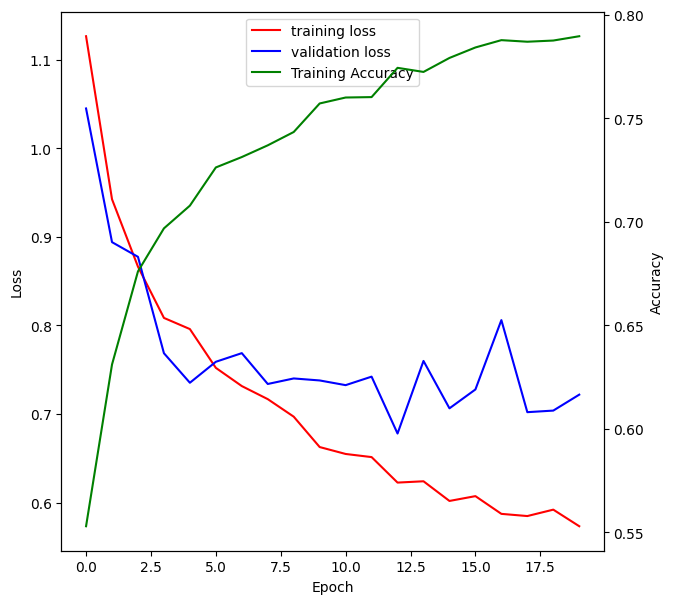

In [66]:
visualize_training_curve(model_0_results)

The chart above illustrates the training process of the LeNet5 deep learning model over 20 epochs, providing details around the interplay between accuracy and loss. Initially, we observe a steep decline in training loss and a corresponding surge in training accuracy very early in the process, indicative of the model’s rapid learning phase. As epochs progress, the training loss exhibits a slower rate, suggesting the onset of convergence within the model’s parameter space.

Notably, the validation loss initially mirrors the training loss but later displays high variability, hinting a potential overfitting. This is where the model excessively adapts to the training data, at the expense of its generalization capabilities. The variability of the validation loss in later epochs could be a sign that the model is beginning to memorize the training data rather than learning to generalize from it.

In contrast, the training accuracy (green line) continues to ascend, as the model further refines its classification ability. This chart reveals the need for strategies like regularization, early stopping, or data augmentation to combat overfitting and enhance the model’s ability to generalize to unseen data. Overall, the LeNet5 model demonstrates good learning characteristics, but careful tuning is required to optimize its performance.

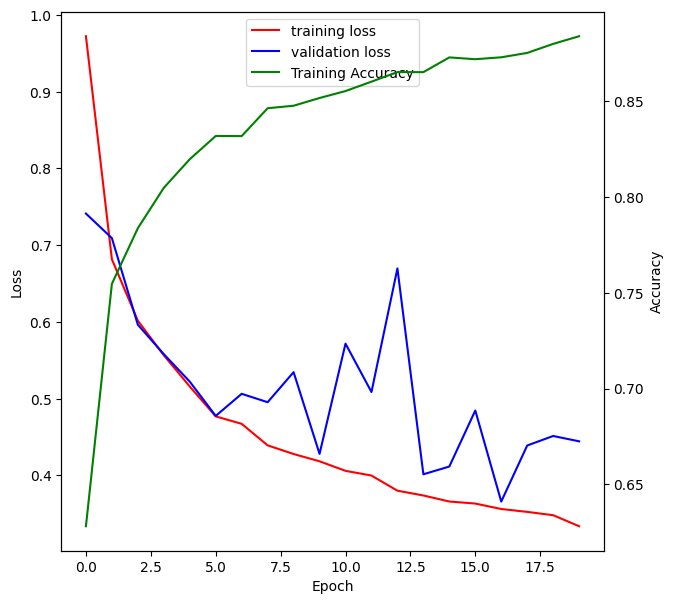

In [67]:
visualize_training_curve(model_1_results)

The chart above presents the training process of the AlexNet mode over 20 epochs as well. The training loss (red line) demonstrates a sharp initial decrease, similar to LeNet5, indicative of the model’s rapid learning from the training data. However, the validation loss (blue line) shows greater variability after epoch 5, suggesting that the model’s performance on the validation set is less stable than LeNet.

The training accuracy (green line) starts at zero and increases sharply, reflecting the model’s improving ability to classify the training data correctly. Nevertheless, it begins to plateau as the epochs advance, which is typical as the model starts to reach its performance limits on the training data.

The fluctuations in validation loss could indicate overfitting.

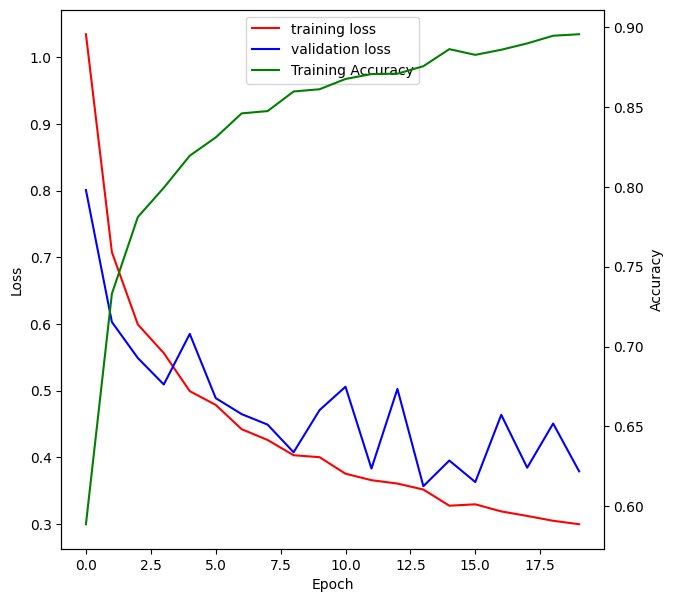

In [103]:
visualize_training_curve(model_2_results)

This last chart presents the training process of VGG Net model. It shows a similar trend to the previous one, however, there are some differences in the behavior of the loss and accuracy curves:

Training Loss indicates a more gradual decrease after the initial drop compared to AlexNet, suggesting a smoother convergence.

Validation Loss, while still showing variability, its variability starts earlier in the epochs and appears to have a steadier decline, indicating better generalization.

And training Accuracy increases sharply and then plateaus, similar to AlexNet and LeNet5. It's a slightly higher plateau though, which may suggest improved model performance on the training set.

Overall, the VGG16 model seems to demonstrate a more stable training process with less overfitting compared to the previous ones. This could be due to a more sophisticated architecture compared to the other two models.

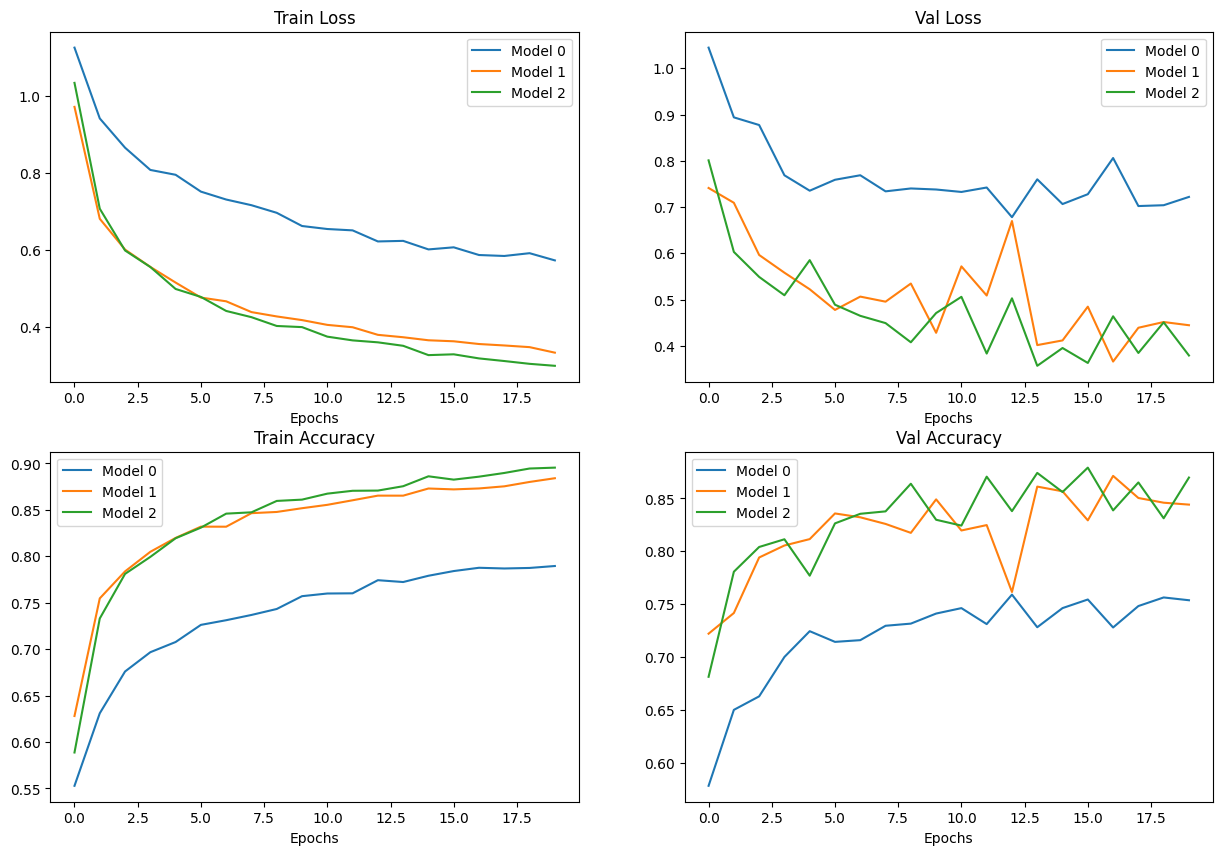

In [105]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_2_df = pd.DataFrame(model_2_results)

# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.plot(epochs, model_2_df["train_loss"], label="Model 2")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["val_loss"], label="Model 0")
plt.plot(epochs, model_1_df["val_loss"], label="Model 1")
plt.plot(epochs, model_2_df["val_loss"], label="Model 2")
plt.title("Val Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.plot(epochs, model_2_df["train_acc"], label="Model 2")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["val_acc"], label="Model 0")
plt.plot(epochs, model_1_df["val_acc"], label="Model 1")
plt.plot(epochs, model_2_df["val_acc"], label="Model 2")
plt.title("Val Accuracy")
plt.xlabel("Epochs")
plt.legend();

The charts above better illustrate the difference of performance between the models. Clearly, LeNet5 (model_0) has the lowest accuracy in the training and validation datasets. AlexNet and VGG16 have very similar performance in accuracy during training and similar variability in the validation accuracy.

The charts above better illustrate the difference of performance between the models. In the "Train Loss" graph, all three models show a downward trend as epochs increase, indicating an improvement in loss on the training set over time. LeNet5 (model_0) has the steepest decline followed by AlexNet (model_1) and then VGG16 (model_2).

The "Val Loss" graph shows fluctuations in loss on the validation set for all models as epochs increase. Unlike the training loss, these lines are not consistently decreasing which may indicate issues like overfitting or instability in learning. LeNet5 seems to have less fluctuation compared to AlexNet and VGG16.

In the "Train Accuracy" graph, there's an upward trend for all models indicating improving accuracy on the training set as more epochs are completed. Here again, LeNet5 shows rapid improvement initially and then stabilizes at a high accuracy level while AlexNet and VGG16 improve more gradually.

Lastly, in the "Val Accuracy" chart, there are significant fluctuations for all models with no clear upward or downward trend. This suggests that none of the models are consistently improving their performance on unseen data (validation set), which could be problematic for real-world problems as generalization is key.

Overall insights from these graphs suggest that while all models improve their performance on training data over time (both in terms of loss and accuracy), their performances on validation data do not show consistent improvement which could be indicative of overfitting or lack of generalization ability.

# Model Performance Comparison

## Test dataset performance

### LeNet5

In [34]:
from torch.utils.data import DataLoader

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_data = datasets.ImageFolder(root=test_images_path, 
                                 transform=test_transforms)

BATCH_SIZE = 32

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=2, 
                             shuffle=False) 

loss_fn = nn.CrossEntropyLoss()

# Evaluate model 0 results
model_0_eval = evaluate_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_function,
    device=device
)
model_0_eval

{'model_name': 'LeNet5',
 'model_loss': 0.7795006632804871,
 'model_acc': 71.81959219858156}

### AlexNet

In [37]:
from torch.utils.data import DataLoader

test_transforms = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_data = datasets.ImageFolder(root=test_images_path, 
                                 transform=test_transforms)

BATCH_SIZE = 32

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=2, 
                             shuffle=False) 

loss_fn = nn.CrossEntropyLoss()

# Evaluate model 1 results
model_1_eval = evaluate_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_function,
    device=device
)
model_1_eval

{'model_name': 'AlexNet',
 'model_loss': 0.45382189750671387,
 'model_acc': 83.80984042553192}

### VGG16

In [41]:
from torch.utils.data import DataLoader

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_data = datasets.ImageFolder(root=test_images_path, 
                                 transform=test_transforms)

BATCH_SIZE = 32

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=2, 
                             shuffle=False) 

loss_fn = nn.CrossEntropyLoss()

# Evaluate model 2 results

# Load model first from disk
model_2 = VGG16(in_channels=3, num_classes=len(train_data.classes))
model_2.load_state_dict(torch.load("./models/model_02_vgg.pth"))
model_2.cuda()

model_2_eval = evaluate_model(model=model_2, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_function,
    device=device
)
model_2_eval

{'model_name': 'VGG16',
 'model_loss': 0.367676705121994,
 'model_acc': 87.79920212765957}

In [42]:
compare_results = pd.DataFrame([model_0_eval, model_1_eval, model_2_eval])
compare_results["training_time_secs"] = [339.234, 752.871, 5247.281]
compare_results

,model_name,model_loss,model_acc,training_time_secs
0,LeNet5,0.779501,71.819592,339.234
1,AlexNet,0.453822,83.809840,752.871
2,VGG16,0.367677,87.799202,5247.281


From the results above we can see that VGGNet performed the best in the test dataset and AlexNet was somewhere close. Something to note though is that VGG16 took 1 hour and 27 minutes to train and LeNet5 with AlexNet took only approx. 5 and 12 minutes respectively to train.

## Confusion Matrix

### LeNet5

Making predictions: 100%|██████████| 94/94 [00:12<00:00,  7.61it/s]


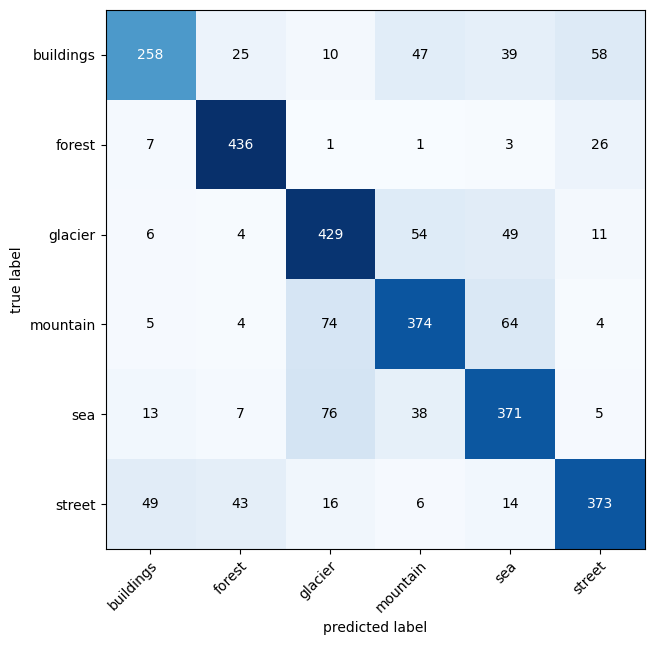

In [102]:
from torch.utils.data import DataLoader

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_data = datasets.ImageFolder(root=test_images_path, 
                                 transform=test_transforms)

BATCH_SIZE = 32

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=2, 
                             shuffle=False) 

plot_conf_matrix(model_0, test_dataloader, test_data, device)

The confusion matrix for the LeNet5 model evaluated against the test data reveals that the model's performance across the six categories: buildings, forest, glacier, mountain, sea, and street. 

- **High Accuracy**: The model shows high accuracy in certain categories, such as 'forest' with 436 correct predictions and 'glacier' with 429 correct predictions. This suggests that LeNet5 is very good at identifying these two specific classes.

- **Misclassifications**: There are notable misclassifications, for example, 'buidings' was often confused with 'street' (58 times) and 'mountain' (47 times).

- **Improvement Areas**: The model could be improved in distinguishing between visually similar categories like 'building' and 'street', as well as 'mountain' and 'glacier'.

The overall performance of the model is a decent one for LeNet5. However, there is room for improvement, especially in reducing the number of false positives and false negatives for certain categories.

### AlexNet

Making predictions: 100%|██████████| 94/94 [00:14<00:00,  6.58it/s]


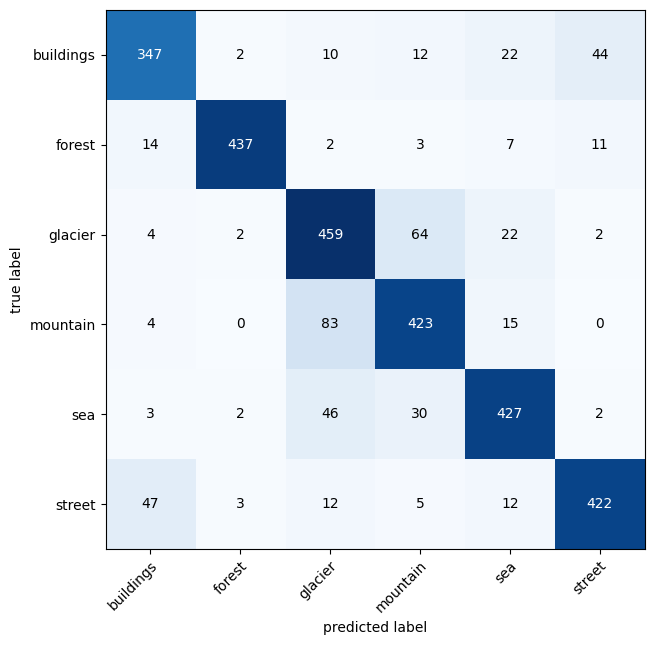

In [98]:
from torch.utils.data import DataLoader

test_transforms = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_data = datasets.ImageFolder(root=test_images_path, 
                                 transform=test_transforms)

BATCH_SIZE = 32

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=2, 
                             shuffle=False) 

plot_conf_matrix(model_1, test_dataloader, test_data, device)

- **Buildings**: AlexNet correctly identified 347 buildings, compared to LeNet5's 258. However, AlexNet had fewer misclassifications with streets.
- **Forest**: AlexNet correctly identified 437 forests, very similar to LeNet5's results, including the overall missclassifications.
- **Glacier**: AlexNet excelled with 459 correct glacier classifications, higher than LeNet5, and fewer confusions with sea.
- **Mountain**: AlexNet correctly classified 423 mountains, an improvement compared to LeNet5, and with fewer errors in general with the other classes.
- **Sea**: AlexNet showed a strong performance with 427 correct sea classifications, higher than LeNet5, with lower misclassifications than LeNet5.
- **Street**: AlexNet correctly identified 422 streets, more than LeNet5, indicating better performance in this category.

Overall, the AlexNet model seems to have a **better balance** between correct classifications and misclassifications, suggesting a **stronger ability to generalize** across various categories when compared to the LeNet5 model. The confusion matrix indicates that AlexNet is particularly more adept at classifying glaciers and forest, which could be attributed to its deeper and more complex architecture allowing for better feature extraction and representation.

### VGG16

Making predictions: 100%|██████████| 94/94 [00:29<00:00,  3.15it/s]


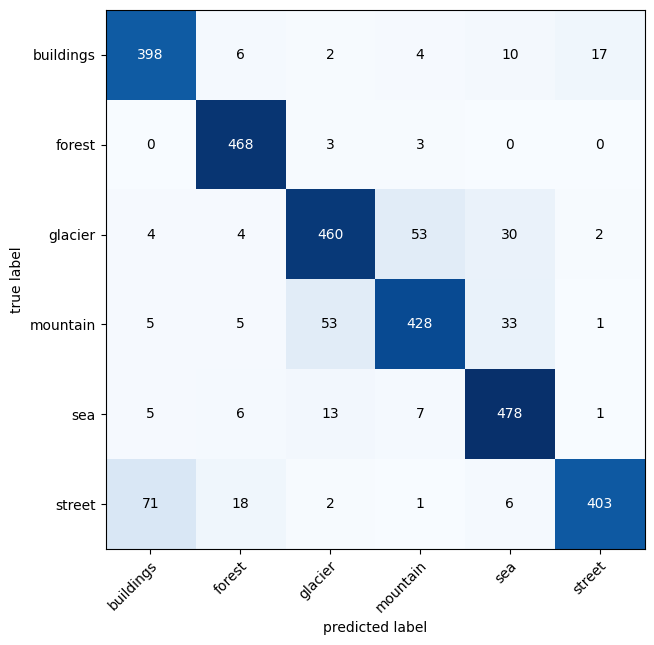

In [93]:
from torch.utils.data import DataLoader

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_data = datasets.ImageFolder(root=test_images_path, 
                                 transform=test_transforms)

BATCH_SIZE = 32

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=2, 
                             shuffle=False) 

plot_conf_matrix(model_2, test_dataloader, test_data, device)

- **Buildings**: VGG16 identified 398 buildings correctly, compared to LeNet5's 258. VGG16 had a significant lower misclassification rate with the 'street' category.
- **Forest**: Both models performed well, with VGG16 correctly identifying 468 forests and LeNet5 identifying 436. It can be noted that VGG16 had a perfect classification with 'sea' and 'street'.
- **Glacier**: VGG16 had 460 correct glacier classifications, which is an improvement over LeNet5's 429.
- **Mountain**: VGG16 correctly classified 428 mountains, which is an improvement from LeNet5's 374. Both models showed some confusion between 'sea' and 'glacier', being VGG16 better at classififying these classes than LeNet5.
- **Sea**: VGG16 excelled with 478 correct sea classifications, showing a significant improvement over LeNet5's 371. VGG16 also had fewer misclassifications in this category.
- **Street**: VGG16 correctly identified 403 streets, which is more than LeNet5's 373. However, VGG16 had a slightly higher number of buildings misclassified as streets.

Overall, the VGG16 model shows a **higher accuracy** in all categories compared to the LeNet5 model. This could be due to VGGNet's deeper architecture, which allows for more complex feature extraction and may lead to better generalization on unseen data. The three models have their strengths and weaknesses, but VGG16's performance suggests it may be more suitable for tasks requiring higher precision in image classification. It can also be suggested that AlexNet model is more effective at distinguishing between specific classes given its good performance classifying 'forest' and 'sea'.